<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Jacobi method

## Contents

In this notebook, we will learn

- How to paralleize a Jacobi method
- How the data partition can impact the performance of a distributed algorithm
- How to use latency hiding



In [2]:
using Printf

function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
gauss_seidel_1_check(answer) = answer_checker(answer,"c")
jacobi_1_check(answer) = answer_checker(answer, "d")
jacobi_2_check(answer) = answer_checker(answer, "b")
jacobi_3_check(answer) = answer_checker(answer, "c")
jacobi_4_check(anwswer) = answer_checker(answer, "d")

jacobi_4_check (generic function with 1 method)

## The Jacobi method


The [Jacobi method](https://en.wikipedia.org/wiki/Jacobi_method) is a numerical tool to solve systems of linear algebraic equations. One of the main applications of the method is to solve boundary value problems (BVPs). I.e., given the values at the boundary (of a grid), the Jacobi method will find the interior values that fulfill a certain equation.



<div>
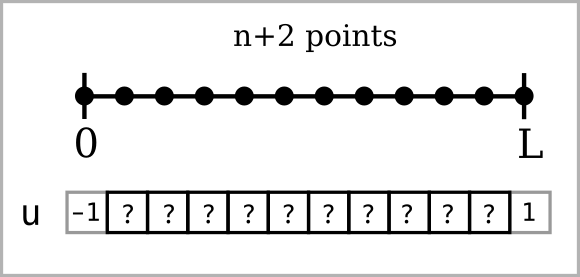
</div>

### Serial implementation

In [ ]:
function jacobi(n,niters)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    u_new = copy(u)
    for t in 1:niters
        for i in 2:(n+1)
            u_new[i] = 0.5*(u[i-1]+u[i+1])
        end
        u, u_new = u_new, u
    end
    u
end

In [ ]:
jacobi(5,1000)

<div class="alert alert-block alert-info">
<b>Note:</b> The values computed by the Jacobi method are linearly increasing from -1 to 1. It is possible to show mathematically that the method we implemented in the function above approximates a 1D Laplace equation via a finite difference method and the solution of this equation is a linear function.
</div>

<div class="alert alert-block alert-info">
<b>Note:</b> In our version of the jacobi method, we return after a given number of iterations. Other stopping criteria are possible. For instance, iterate until the difference between u and u_new is below a tolerance. 
</div>


### Where can we exploit parallelism?

Look at the two nested loops in the sequential implementation:

```julia
for t in 1:nsteps
    for i in 2:(n+1)
        u_new[i] = 0.5*(u[i-1]+u[i+1])
    end
    u, u_new = u_new, u
end
```

- The outer loop cannot be parallelized. The value of `u` at step `t+1` depends on the value at the previous step `t`.
- The inner loop can be parallelized.



### The Gauss-Seidel method

The usage of `u_new` seems a bit unnecessary at first sight, right?. If we remove it, we get another method called Gauss-Seidel.



In [ ]:
function gauss_seidel(n,niters)
    u = zeros(n+2)
    u[1] = -1
    u[end] = 1
    for t in 1:niters
        for i in 2:(n+1)
            u[i] = 0.5*(u[i-1]+u[i+1])
        end
    end
    u
end

Note that the final solution is the same (up to machine precision).

In [ ]:
gauss_seidel(5,1000)

<div class="alert alert-block alert-success">
<b>Question:</b>  Which of the two loops in the Gauss-Seidel method are trivially parallelizable?
</div>

```julia
for t in 1:niters
    for i in 2:(n+1)
        u[i] = 0.5*(u[i-1]+u[i+1])
    end
end
```

    a) Both of them
    b) The outer, but not the inner
    c) None of them
    d) The inner, but not the outer


In [ ]:
answer = "x" # replace x with a, b, c or d
gauss_seidel_1_check(answer)

## Parallelization of the Jacobi method



### Parallelization strategy

- Each worker updates a consecutive section of the array `u_new` 



### Data dependencies

Recall:

`u_new[i] = 0.5*(u[i-1]+u[i+1])`


Thus, each process will need values from the neighboring processes to perform the update of its boundary values.

<div>
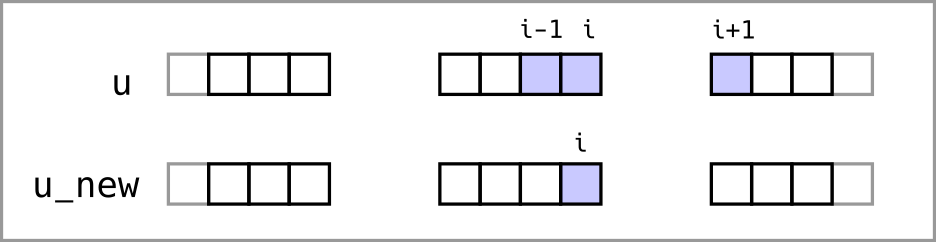
</div>

### Ghost (aka halo) cells

A usual way of handling this type of data dependencies is using so-called ghost cells. Ghost cells represent the missing data dependencies in the data owned by each process. After importing the appropriate values from the neighbor processes one can perform the usual sequential Jacobi update locally in the processes.

<div>
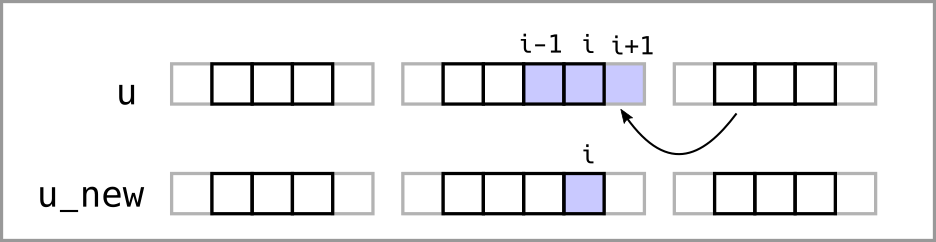
</div>

<div class="alert alert-block alert-success">
<b>Question:</b>  Which is the communication and computation complexity in each process? N is the length of the vector and P the number of processes.    
</div>

    a) Communication: O(P), computation: O(N/P)
    b) Communication: O(1), computation: O(N)
    c) Communication: O(P), computation: O(N)
    d) Communication: O(1), computation: O(N/P)

In [ ]:
answer = "x" # replace x with a, b, c or d
jacobi_1_check(answer)

## Implementation

We consider the implementation using MPI. The programming model of MPI is generally better suited for data-parallel algorithms like this one than the task-based model provided by Distributed.jl. In any case, one can also implement it using Distributed, but it requires some extra effort to setup remote channels right for the communication between neighbor processes.

Take a look at the implementation below and try to understand it. Note that we have used MPIClustermanagers and Distributed just to run the MPI code on the notebook. When running it on a cluster, MPIClustermanagers and Distributed are not needed.


In [ ]:
] add MPI MPIClusterManagers

In [ ]:
using MPIClusterManagers 
using Distributed

In [ ]:
if procs() == workers()
    nw = 3
    manager = MPIWorkerManager(nw)
    addprocs(manager)
end

In [ ]:
# Test cell, remove me
u = [-1, 0, 0, 0, 0, 1]
view(u, 6:6)

In [ ]:
@mpi_do manager begin
    using MPI
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    nw = MPI.Comm_size(comm)
    iw = MPI.Comm_rank(comm)+1
    function jacobi_mpi(n,niters)
        if mod(n,nw) != 0
            println("n must be a multiple of nw")
            MPI.Abort(comm,1)
        end
        n_own = div(n,nw)
        u = zeros(n_own+2)
        u[1] = -1
        u[end] = 1
        u_new = copy(u)
        for t in 1:niters
            reqs = MPI.Request[]
            # Exchange cell values with neighbors
            if iw != 1
                neig_rank = (iw-1)-1
                req = MPI.Isend(view(u,2:2),comm,dest=neig_rank,tag=0)
                push!(reqs,req)
                req = MPI.Irecv!(view(u,1:1),comm,source=neig_rank,tag=0)
                push!(reqs,req)
            end
            if iw != nw
                neig_rank = (iw+1)-1
                s = n_own+1
                r = n_own+2
                req = MPI.Isend(view(u,s:s),comm,dest=neig_rank,tag=0)
                push!(reqs,req)
                req = MPI.Irecv!(view(u,r:r),comm,source=neig_rank,tag=0)
                push!(reqs,req)
            end
            MPI.Waitall(reqs)
            for i in 2:(n_own+1)
                u_new[i] = 0.5*(u[i-1]+u[i+1])
            end
            u, u_new = u_new, u
        end
        u
        @show u
        # Gather results in root process
        results = zeros(n+2)
        results[1] = -1
        results[n+2] = 1
        MPI.Gather!(view(u,2:n_own+1), view(results, 2:n+1), root=0, comm)
        if iw == 1
            @show results
        end            
    end
    niters = 100
    load = 4
    n = load*nw
    jacobi_mpi(n,niters)
end

<div class="alert alert-block alert-success">
<b>Question:</b>  How many messages per iteration are sent from a process away from the boundary?
</div>

    a) 1
    b) 2
    c) 3
    d) 4



In [ ]:
answer = "x" # replace x with a, b, c or d
jacobi_2_check(answer)

<div class="alert alert-block alert-success">
<b>Question:</b>  After the end of the for-loop (line 43), ...
</div>

    a) each worker holds the complete solution.
    b) the root process holds the solution. 
    c) the ghost cells contain redundant values. 
    d) all ghost cells contain the initial values -1 and 1. 

In [ ]:
answer = "x" # replace x with a, b, c or d
jacobi_3_check(answer)

<div class="alert alert-block alert-success">
<b>Question:</b>  In line 35 of the code, we wait for all receive and send requests. Is it possible to instead wait for just the receive requests?
</div>

  
    a) No, because the send buffer might be overwritten if we don't wait for send requests.
    b) No, because MPI does not allow an asynchronous send without a Wait().
    c) Yes, because each send has a matching receive, so all requests are done when the receive requests return.  
    d) Yes, because there are no writes to the send buffer in this iteration.

In [ ]:
answer = "x" # replace x with a, b, c or d.
jacobi_4_check(answer)

### Latency hiding

Note that we only need communications to update the values at the boundary of the portion owned by each process. The other values (the one in green in the figure below) can be updated without communications. This provides the opportunity of overlapping the computation of the interior values (green cells in the figure) with the communication of the ghost values. This technique is called latency hiding, since we are hiding communication latency by overlapping it with communications that we need to do anyway.

The modification of the implementation above to include latency hiding is leaved as an exercise (see below).


<div>
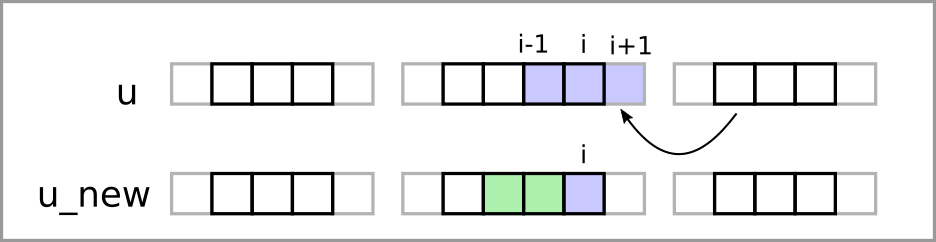
</div>

## Extension to 2D

### Serial implementation

In [ ]:
function jacobi_2d(n,niters)
    u = zeros(n+2,n+2)
    u[1,:] = u[end,:] = u[:,1] = u[:,end] .= 1
    heater = 1/n^2
    u_new = copy(u)
    for t in 1:niters
        for j in 2:(n+1)
            for i in 2:(n+1)
                north = u[i,j+1]
                south = u[i,j-1]
                east = u[i+1,j]
                west = u[i-1,j]
                u_new[i,j] = 0.25*(north+south+east+west) + heater
            end
        end
        u, u_new = u_new, u
    end
    u
end

In [ ]:
u = jacobi_2d(100,1000)

## Exercises

### Exercise 1

Transform the following parallel implementation of the 1d Jacobi method (it is copied from above) to use latency hiding (overlap between computation of interior values and communication)

In [ ]:
@mpi_do manager begin
    using MPI
    comm = MPI.Comm_dup(MPI.COMM_WORLD)
    nw = MPI.Comm_size(comm)
    iw = MPI.Comm_rank(comm)+1
    function jacobi_mpi(n,niters)
        if mod(n,nw) != 0
            println("n must be a multiple of nw")
            MPI.Abort(comm,1)
        end
        n_own = div(n,nw)
        u = zeros(n_own+2)
        u[1] = -1
        u[end] = 1
        u_new = copy(u)
        for t in 1:niters
            reqs = MPI.Request[]
            # Exchange cell values with neighbors
            if iw != 1
                neig_rank = (iw-1)-1
                req = MPI.Isend(view(u,2:2),comm,dest=neig_rank,tag=0)
                push!(reqs,req)
                req = MPI.Irecv!(view(u,1:1),comm,source=neig_rank,tag=0)
                push!(reqs,req)
            end
            if iw != nw
                neig_rank = (iw+1)-1
                s = n_own+1
                r = n_own+2
                req = MPI.Isend(view(u,s:s),comm,dest=neig_rank,tag=0)
                push!(reqs,req)
                req = MPI.Irecv!(view(u,r:r),comm,source=neig_rank,tag=0)
                push!(reqs,req)
            end
            MPI.Waitall(reqs)
            for i in 2:(n_own+1)
                u_new[i] = 0.5*(u[i-1]+u[i+1])
            end
            u, u_new = u_new, u
        end
        u
        @show u
        # Gather results in root process
        results = zeros(n+2)
        results[1] = -1
        results[n+2] = 1
        MPI.Gather!(view(u,2:n_own+1), view(results, 2:n+1), root=0, comm)
        if iw == 1
            @show results
        end            
    end
    niters = 100
    load = 4
    n = load*nw
    jacobi_mpi(n,niters)
end